In [0]:
import numpy as np
with open('reviews.txt','r') as f:
  reviews = f.read()
with open('labels.txt','r') as f:
  labels = f.read()

In [0]:
from string import punctuation
reviews = reviews.lower()
all_text = ''.join([c for c in reviews if c not in punctuation])
# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])


In [0]:
# 1=positive, 0=negative label conversion
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

In [0]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.

# get indices of any reviews with length 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Zero-length reviews: 1
Maximum review length: 2514
Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


In [0]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

In [0]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,    58,   841,   135],
        [   11,     6,   179,  ...,  1350, 14809,   167],
        [ 1011,  1377,     7,  ...,  2962,    12,    10],
        ...,
        [   54,    10,    84,  ...,    32,   117,     3],
        [   11,    18,     6,  ...,  6009,     4,     1],
        [    0,     0,     0,  ...,     3,   759,  2383]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1])


In [0]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


### QRNN
The implementation is based on the architecture presented in https://arxiv.org/abs/1611.01576. The QRNN combines the methodologies used in convolutional neural networks and recurrent neural networks to increase the performance of the architecture and increasing the computation speed. For this implementation, 2 layers are used with a kernel size of 2 and 256 filters in each layer. 


In [0]:
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

class QRNNLayer(nn.Module):
    def __init__(self,batch_size,input_size,n_filters,kernel_size,embed_size,device,dropout):
        super(QRNNLayer,self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.embed_size = embed_size
        self.dropout = torch.nn.Dropout(dropout)
        self.device = device
        self.conv1 = torch.nn.Conv1d(self.input_size,self.n_filters,self.kernel_size)
        self.conv2 = torch.nn.Conv1d(self.input_size,self.n_filters,self.kernel_size)
        self.conv3 = torch.nn.Conv1d(self.input_size,self.n_filters,self.kernel_size)
    
    def forward(self,masked_input, h, c):
        Z,F,O = self.masked_conv(masked_input)
        h, c = self.pool(c,Z,F,O)
        masked_input = h
        return masked_input,h,c
    def masked_conv(self,x):
        pad = torch.zeros([self.batch_size,1,self.input_size],device=self.device)
        x = torch.cat([pad,x],1).permute(0,2,1)
        Z = torch.tanh((self.conv1(x)))
        F = torch.sigmoid((self.conv2(x)))
        O = torch.sigmoid((self.conv3(x)))
        one_mask = torch.ones_like(F,device=self.device) - F
        F = 1 - self.dropout(one_mask)
        return Z.permute(0,2,1), F.permute(0,2,1), O.permute(0,2,1)
    def pool(self, prev_c,Z,F,O):
        c = torch.mul(F,prev_c) + torch.mul(1-F,Z)
        h = torch.mul(O,c)
        return h,c

class QRNN(nn.Module):
    def __init__(self,vocab_size,embed_size,n_filters,kernel_size,batch_size,seq_len,layers,device,dropout):
        super(QRNN,self).__init__()
        self.embed_size = embed_size
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.num_layer = layers
        self.device = device
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.dense = torch.nn.Linear(self.seq_len*self.n_filters,1)
        self.QRNN_layers = torch.nn.ModuleList([QRNNLayer(self.batch_size,embed_size if l ==0 else n_filters,
                                                         self.n_filters,self.kernel_size,self.embed_size,self.device,
                                                         dropout,) for l in range(self.num_layer)])
        
        
    def forward(self,x,target):
        x = self.embedding(x)
        h = torch.zeros([self.batch_size,self.seq_len,self.n_filters],device=self.device)
        c = torch.zeros_like(h,device=self.device)
        
        masked_input = x
        for l,layer in enumerate(self.QRNN_layers):
            masked_input,h,c = layer(masked_input,h,c)
        dense_input = h.view([self.batch_size,-1])
        logits = self.dense(dense_input)
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy

In [0]:
import time
epochs = 10
n_filters = 256
kernel_size = 2
layers= 2
learning_rate = 0.001
vocab_size = len(vocab_to_int)+1
embed_dims = 300
seq_len = 200
dropout = 0.3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = QRNN(vocab_size,embed_dims,n_filters,kernel_size,batch_size,seq_len,layers,device,dropout).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
QRNN_acc = []
QRNN_valacc = []

model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        QRNN_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("Val Loss: {:.3f}".format(np.mean(val_loss)), "\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                QRNN_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
  print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 	Train Loss: 0.694 	Train Accuracy: 40.00
Val Loss: 0.697 	Val Acc: 49.840
Epoch: 0/10 	Iteration: 10 	Train Loss: 0.706 	Train Accuracy: 60.00
Epoch: 0/10 	Iteration: 20 	Train Loss: 0.708 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 30 	Train Loss: 0.676 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 40 	Train Loss: 0.719 	Train Accuracy: 38.00
Epoch: 0/10 	Iteration: 50 	Train Loss: 0.687 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 60 	Train Loss: 0.743 	Train Accuracy: 46.00
Epoch: 0/10 	Iteration: 70 	Train Loss: 0.619 	Train Accuracy: 72.00
Epoch: 0/10 	Iteration: 80 	Train Loss: 0.654 	Train Accuracy: 68.00
Epoch: 0/10 	Iteration: 90 	Train Loss: 0.583 	Train Accuracy: 66.00
Epoch: 0/10 	Iteration: 100 	Train Loss: 0.616 	Train Accuracy: 70.00
Epoch: 0/10 	Iteration: 110 	Train Loss: 0.530 	Train Accuracy: 78.00
Epoch: 0/10 	Iteration: 120 	Train Loss: 0.645 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 130 	Train Loss: 0.543 	Train Accuracy: 74.0

## Basic GRU Cell (Unidirectional)
The Gated Recurrent Unit is a recurrent neural network with a gating mechansism introduced in https://arxiv.org/abs/1406.1078. 



In [0]:
class UniGRU(nn.Module):
    def __init__(self,vocab_size,embed_size,num_units,output_size,dropout,seq_len,batch_size):
        super(UniGRU, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.batch_size = batch_size

        self.rnn = torch.nn.GRU(embed_size,num_units,num_layers=1,bidirectional=False)
        self.dense = torch.nn.Linear(seq_len*num_units,output_size)
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self,x,target):
        embed_input = self.embedding(x)
        embed_input = self.dropout(embed_input)
        output, hidden = self.rnn(embed_input)
        logits = self.dense(output.view([self.batch_size,-1]))
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy

      
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 50
num_units = 256
learning_rate = 0.001
embed_dims = 300
seq_len = 200
dropout = 0.5
vocab_size = len(vocab_to_int)+1
model = UniGRU(vocab_size,embed_dims,num_units,1,dropout,seq_len,batch_size).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
GRU_acc = []
GRU_valacc = []
model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        GRU_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("Val Loss: {:.3f}".format(np.mean(val_loss)), "\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                GRU_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 	Train Loss: 0.691 	Train Accuracy: 56.00
Val Loss: 1.335 	Val Acc: 49.960
Epoch: 0/10 	Iteration: 10 	Train Loss: 0.711 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 20 	Train Loss: 0.761 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 30 	Train Loss: 0.738 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 40 	Train Loss: 0.872 	Train Accuracy: 42.00
Epoch: 0/10 	Iteration: 50 	Train Loss: 0.686 	Train Accuracy: 70.00
Epoch: 0/10 	Iteration: 60 	Train Loss: 0.669 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 70 	Train Loss: 0.792 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 80 	Train Loss: 0.742 	Train Accuracy: 58.00
Epoch: 0/10 	Iteration: 90 	Train Loss: 0.772 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 100 	Train Loss: 0.798 	Train Accuracy: 58.00
Epoch: 0/10 	Iteration: 110 	Train Loss: 0.821 	Train Accuracy: 48.00
Epoch: 0/10 	Iteration: 120 	Train Loss: 0.783 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 130 	Train Loss: 0.774 	Train Accuracy: 60.0

In [0]:
## Basic LSTM Cell (Unidirectional)

In [0]:
class UniLSTM(nn.Module):
    def __init__(self,vocab_size,embed_size,num_units,output_size,dropout,seq_len,batch_size):
        super(UniLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.batch_size = batch_size
        self.rnn = torch.nn.LSTM(embed_size,num_units,num_layers=1,bidirectional=False)
        self.dense = torch.nn.Linear(seq_len*num_units,output_size)
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self,x,target):
        embed_input = self.embedding(x)
        embed_input = self.dropout(embed_input)
        output, hidden = self.rnn(embed_input)
        logits = self.dense(output.view([self.batch_size,-1]))
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy
      
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 50
num_units = 256
learning_rate = 0.001
embed_dims = 300
seq_len = 200
dropout = 0.5
vocab_size = len(vocab_to_int)+1

model = UniLSTM(vocab_size,embed_dims,num_units,1,dropout,seq_len,batch_size).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
UniLSTM_acc = []
UniLSTM_valacc = []
model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        UniLSTM_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("Val Loss: {:.3f}".format(np.mean(val_loss)), "\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                UniLSTM_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 	Train Loss: 0.696 	Train Accuracy: 60.00
Val Loss: 0.750 	Val Acc: 50.080
Epoch: 0/10 	Iteration: 10 	Train Loss: 0.713 	Train Accuracy: 42.00
Epoch: 0/10 	Iteration: 20 	Train Loss: 0.657 	Train Accuracy: 64.00
Epoch: 0/10 	Iteration: 30 	Train Loss: 0.719 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 40 	Train Loss: 0.740 	Train Accuracy: 46.00
Epoch: 0/10 	Iteration: 50 	Train Loss: 0.677 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 60 	Train Loss: 0.719 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 70 	Train Loss: 0.698 	Train Accuracy: 56.00
Epoch: 0/10 	Iteration: 80 	Train Loss: 0.664 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 90 	Train Loss: 0.716 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 100 	Train Loss: 0.650 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 110 	Train Loss: 0.733 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 120 	Train Loss: 0.632 	Train Accuracy: 66.00
Epoch: 0/10 	Iteration: 130 	Train Loss: 0.725 	Train Accuracy: 50.0

In [0]:
## Basic LSTM Cell (Bidirectional)

In [0]:
class BiLSTM(nn.Module):
    def __init__(self,vocab_size,embed_size,num_units,output_size,dropout,seq_len,batch_size):
        super(BiLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.batch_size = batch_size
        self.rnn = torch.nn.LSTM(embed_size,num_units,num_layers=1,bidirectional=True)
        self.dense = torch.nn.Linear(seq_len*num_units*2,output_size)
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self,x,target):
        embed_input = self.embedding(x)
        embed_input = self.dropout(embed_input)
        output, hidden = self.rnn(embed_input)

        logits = self.dense(output.view([self.batch_size,-1]))
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 50
num_units = 256
learning_rate = 0.001
embed_dims = 300
seq_len = 200
dropout = 0.5
vocab_size = len(vocab_to_int)+1

model = BiLSTM(vocab_size,embed_dims,num_units,1,dropout,seq_len,batch_size).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
BiLSTM_acc = []
BiLSTM_valacc = []
model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        BiLSTM_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("Val Loss: {:.3f}".format(np.mean(val_loss)), "\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                BiLSTM_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 	Train Loss: 0.698 	Train Accuracy: 46.00
Val Loss: 0.897 	Val Acc: 49.960
Epoch: 0/10 	Iteration: 10 	Train Loss: 0.693 	Train Accuracy: 58.00
Epoch: 0/10 	Iteration: 20 	Train Loss: 0.699 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 30 	Train Loss: 0.719 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 40 	Train Loss: 0.735 	Train Accuracy: 48.00
Epoch: 0/10 	Iteration: 50 	Train Loss: 0.681 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 60 	Train Loss: 0.653 	Train Accuracy: 66.00
Epoch: 0/10 	Iteration: 70 	Train Loss: 0.666 	Train Accuracy: 68.00
Epoch: 0/10 	Iteration: 80 	Train Loss: 0.683 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 90 	Train Loss: 0.732 	Train Accuracy: 56.00
Epoch: 0/10 	Iteration: 100 	Train Loss: 0.721 	Train Accuracy: 58.00
Epoch: 0/10 	Iteration: 110 	Train Loss: 0.795 	Train Accuracy: 46.00
Epoch: 0/10 	Iteration: 120 	Train Loss: 0.749 	Train Accuracy: 60.00
Epoch: 0/10 	Iteration: 130 	Train Loss: 0.716 	Train Accuracy: 56.0

In [0]:
## Multi-Layer Bidirectional LSTM

In [0]:
class MBiLSTM(nn.Module):
    def __init__(self,vocab_size,embed_size,num_units,output_size,dropout,seq_len,batch_size,num_layers):
        super(MBiLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.batch_size = batch_size
        self.rnn = torch.nn.LSTM(embed_size,num_units,num_layers=num_layers,bidirectional=True)
        self.dense = torch.nn.Linear(seq_len*num_units*2,output_size)
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self,x,target):
        embed_input = self.embedding(x)
        embed_input = self.dropout(embed_input)
        output, hidden = self.rnn(embed_input)
        
        logits = self.dense(output.view([self.batch_size,-1]))
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy
      
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 50
num_units = 256
learning_rate = 0.001
embed_dims = 300
seq_len = 200
dropout = 0.5
vocab_size = len(vocab_to_int)+1
num_layers = 2

model = MBiLSTM(vocab_size,embed_dims,num_units,1,dropout,seq_len,batch_size,num_layers).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
MBiLSTM_acc = []
MBiLSTM_valacc = []
model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        MBiLSTM_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("Val Loss: {:.3f}".format(np.mean(val_loss)), "\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                MBiLSTM_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 	Train Loss: 0.695 	Train Accuracy: 52.00
Val Loss: 0.947 	Val Acc: 50.000
Epoch: 0/10 	Iteration: 10 	Train Loss: 0.688 	Train Accuracy: 56.00
Epoch: 0/10 	Iteration: 20 	Train Loss: 0.703 	Train Accuracy: 46.00
Epoch: 0/10 	Iteration: 30 	Train Loss: 0.700 	Train Accuracy: 48.00
Epoch: 0/10 	Iteration: 40 	Train Loss: 0.723 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 50 	Train Loss: 0.705 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 60 	Train Loss: 0.710 	Train Accuracy: 44.00
Epoch: 0/10 	Iteration: 70 	Train Loss: 0.695 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 80 	Train Loss: 0.700 	Train Accuracy: 48.00
Epoch: 0/10 	Iteration: 90 	Train Loss: 0.659 	Train Accuracy: 64.00
Epoch: 0/10 	Iteration: 100 	Train Loss: 0.695 	Train Accuracy: 50.00
Epoch: 0/10 	Iteration: 110 	Train Loss: 0.845 	Train Accuracy: 44.00
Epoch: 0/10 	Iteration: 120 	Train Loss: 0.675 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 130 	Train Loss: 0.709 	Train Accuracy: 54.0

In [0]:
## Convolutional Neural Network

In [0]:
class CNN(nn.Module):
    def __init__(self,vocab_size,embed_size,filter_size,kernel_size,dropout,seq_len):
        super(CNN, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embed_size)
        self.conv1 = torch.nn.Conv2d(1,filter_size,kernel_size=[kernel_size[0],embed_size])
        self.conv2 = torch.nn.Conv2d(1,filter_size,kernel_size=[kernel_size[1],embed_size])
        self.conv3 = torch.nn.Conv2d(1,filter_size,kernel_size=[kernel_size[2],embed_size])
        self.mp1 = torch.nn.MaxPool1d(seq_len+1-kernel_size[0])
        self.mp2 = torch.nn.MaxPool1d(seq_len+1-kernel_size[1])
        self.mp3 = torch.nn.MaxPool1d(seq_len+1-kernel_size[2])
        self.dense = torch.nn.Linear(filter_size*3,1)
        self.dropout = torch.nn.Dropout(dropout)
    def forward(self,x,target):
        embed_input = self.embedding(x)
        embed_input.unsqueeze_(1)
        x1 = torch.tanh(self.dropout(self.conv1(embed_input))).squeeze(3)
        x2 = torch.tanh(self.dropout(self.conv2(embed_input))).squeeze(3)
        x3 = torch.tanh(self.dropout(self.conv3(embed_input))).squeeze(3)
        f1 = self.mp1(x1).squeeze(2)
        f2 = self.mp2(x2).squeeze(2)
        f3 = self.mp3(x3).squeeze(2)
        hidden = torch.cat([f1,f2,f3],dim=1)
        logits = self.dense(hidden)
        prediction = torch.sigmoid(logits)
        target = target.view([-1,1])
        correct_pred = torch.eq(torch.round(prediction).type(target.type()),target)
        accuracy = torch.sum(correct_pred)
        return prediction, accuracy
   
  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 50
learning_rate = 0.001
embed_size = 300
seq_len = 1250
dropout = 0.5
filter_size = 100
vocab_size = len(vocab_to_int)+1
kernel_size = [3,4,5]
model = CNN(vocab_size,embed_dims,filter_size,kernel_size,dropout,seq_len).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
counter = 0
CNN_acc = []
CNN_valacc = []
model.train()
for e in range(epochs):
  start_time = time.time()
  for inputs, labels in train_loader:
    
    inputs, labels = inputs.cuda(), labels.cuda()
    model.zero_grad()
    logits, accuracy = model(inputs,labels)
    loss = criterion(logits,labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    if counter%10==0:
        print("Epoch: {}/{}".format(e,epochs),
                     "\tIteration: {}".format(counter),
                     "\t\tTrain Loss: {:.3f}".format(loss.item()),
                     "\tTrain Accuracy: {:.2f}".format(accuracy.item()*100/batch_size))
        CNN_acc.append(accuracy.item()*100/batch_size)
    if counter%399==0:
            with torch.no_grad():
                model.eval()
                val_acc = []
                val_loss = []
                for inputs, labels in valid_loader:
                    inputs_val, labels_val = inputs.cuda(), labels.cuda()
                    logits_val,accuracy_val = model(inputs_val,labels_val)
                    loss_val = criterion(logits_val,labels_val.float())
                    val_acc.append(accuracy_val.item()*100/batch_size)
                    val_loss.append(loss_val.item())
                print("\t\tVal Loss: {:.3f}".format(np.mean(val_loss)), "\t\tVal Acc: {:.3f}".format(np.mean(val_acc)))
                CNN_valacc.append(np.mean(val_acc))
                model.train()
    counter += 1
  print("Time to train epoch: {0} s".format(time.time()-start_time))  
with torch.no_grad():
  model.eval()
  test_acc = []
  test_loss = []
  for inputs, labels in test_loader:
    input_test, labels_test = inputs.cuda(), labels.cuda()
    logits_test,accuracy_test = model(input_test,labels_test)
    loss_test = criterion(logits_test,labels_test.float())
    test_acc.append(accuracy_test.item()*100/batch_size)
    test_loss.append(loss_test.item())
print("Test Loss: {:.3f}".format(np.mean(test_loss)), "\tTest Acc: {:.3f}".format(np.mean(test_acc)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0/10 	Iteration: 0 		Train Loss: 0.786 	Train Accuracy: 52.00
		Val Loss: 0.732 		Val Acc: 50.000
Epoch: 0/10 	Iteration: 10 		Train Loss: 0.700 	Train Accuracy: 40.00
Epoch: 0/10 	Iteration: 20 		Train Loss: 0.704 	Train Accuracy: 38.00
Epoch: 0/10 	Iteration: 30 		Train Loss: 0.692 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 40 		Train Loss: 0.737 	Train Accuracy: 36.00
Epoch: 0/10 	Iteration: 50 		Train Loss: 0.678 	Train Accuracy: 56.00
Epoch: 0/10 	Iteration: 60 		Train Loss: 0.694 	Train Accuracy: 44.00
Epoch: 0/10 	Iteration: 70 		Train Loss: 0.688 	Train Accuracy: 54.00
Epoch: 0/10 	Iteration: 80 		Train Loss: 0.677 	Train Accuracy: 62.00
Epoch: 0/10 	Iteration: 90 		Train Loss: 0.692 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 100 		Train Loss: 0.687 	Train Accuracy: 56.00
Epoch: 0/10 	Iteration: 110 		Train Loss: 0.688 	Train Accuracy: 64.00
Epoch: 0/10 	Iteration: 120 		Train Loss: 0.692 	Train Accuracy: 52.00
Epoch: 0/10 	Iteration: 130 		Train Loss: 0.693 	Tra

In [0]:
import numpy as np
import pandas as pd
iter = np.arange(0,4000,10)
ep = [0,1,2,3,4,5,6,7,8,9,10]
d = {'QRNN':QRNN_acc,'1 Layer GRU':GRU_acc,'UniLSTM':UniLSTM_acc,'BiLSTM':BiLSTM_acc,'Multi Layer BiLSTM':MBiLSTM_acc,'CNN':CNN_acc}
d2 = {'QRNN':QRNN_valacc,'1 Layer GRU':GRU_valacc,'UniLSTM':UniLSTM_valacc,'BiLSTM':BiLSTM_valacc,'Multi Layer BiLSTM':MBiLSTM_valacc,'CNN':CNN_valacc}
df_acc = pd.DataFrame(data=d,index=iter)
df_val = pd.DataFrame(data=d2,index=ep)

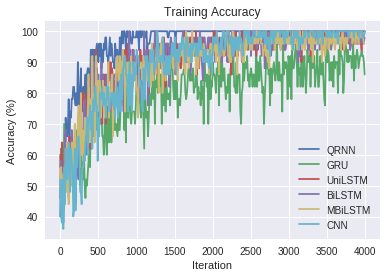

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
plt.plot(iter,QRNN_acc,label='QRNN')
plt.plot(iter,GRU_acc,label='GRU')
plt.plot(iter,UniLSTM_acc,label='UniLSTM')
plt.plot(iter,BiLSTM_acc,label='BiLSTM')
plt.plot(iter,MBiLSTM_acc,label='MBiLSTM')
plt.plot(iter,CNN_acc,label='CNN')
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

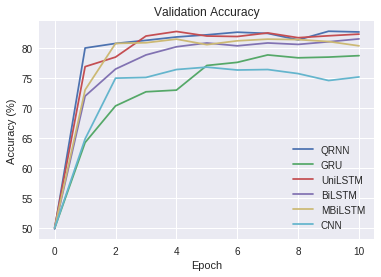

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
plt.plot(ep,QRNN_valacc,label='QRNN')
plt.plot(ep,GRU_valacc,label='GRU')
plt.plot(ep,UniLSTM_valacc,label='UniLSTM')
plt.plot(ep,BiLSTM_valacc,label='BiLSTM')
plt.plot(ep,MBiLSTM_valacc,label='MBiLSTM')
plt.plot(ep,CNN_valacc,label='CNN')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

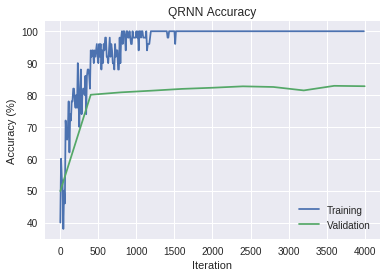

In [0]:
e = [0,400,800,1200,1600,2000,2400,2800,3200,3600,4000]
plt.plot(iter,QRNN_acc,label='Training')
plt.plot(e,QRNN_valacc,label='Validation')
plt.title('QRNN Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

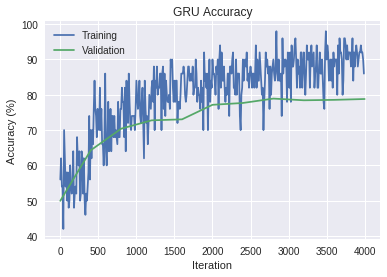

In [0]:
plt.plot(iter,GRU_acc,label='Training')
plt.plot(e,GRU_valacc,label='Validation')
plt.title('GRU Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

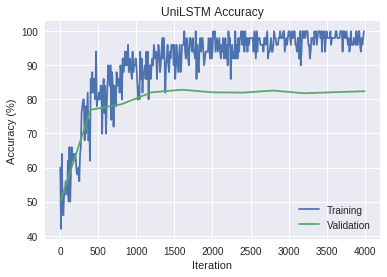

In [0]:
plt.plot(iter,UniLSTM_acc,label='Training')
plt.plot(e,UniLSTM_valacc,label='Validation')
plt.title('UniLSTM Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

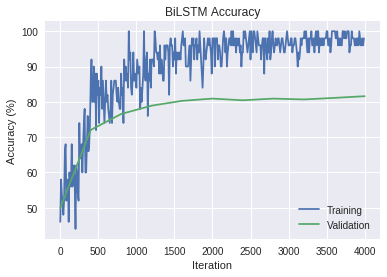

In [0]:
plt.plot(iter,BiLSTM_acc,label='Training')
plt.plot(e,BiLSTM_valacc,label='Validation')
plt.title('BiLSTM Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

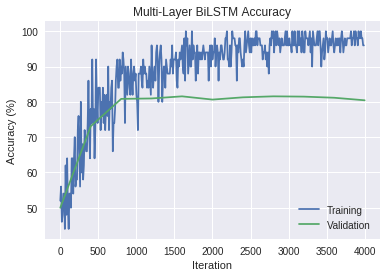

In [0]:
plt.plot(iter,MBiLSTM_acc,label='Training')
plt.plot(e,MBiLSTM_valacc,label='Validation')
plt.title('Multi-Layer BiLSTM Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()

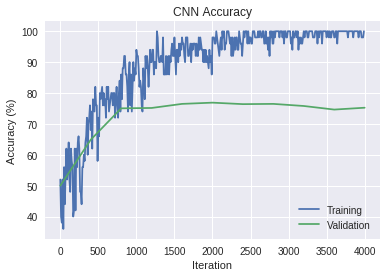

In [0]:
plt.plot(iter,CNN_acc,label='Training')
plt.plot(e,CNN_valacc,label='Validation')
plt.title('CNN Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()